In [19]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [20]:
CSV_IN = 'datos/Base datos_INTA_ascii.csv'
CSV_OUT = CSV_IN.replace('.csv', '_limpio.csv')

print 'Cargando datos de "%s"' % CSV_IN
df = pd.read_csv(CSV_IN)
print 'Cargado dataframe de tamaño %d x %d' % df.shape
# df.head()

Cargando datos de "datos/Base datos_INTA_ascii.csv"
Cargado dataframe de tamaño 423 x 44


In [21]:
def guardar():
    df.to_csv(CSV_OUT, index=None)

In [22]:
cols = list(df.columns)
for c in cols:
    if c.startswith('Unnamed'):
        df = df.drop(c, axis=1)
guardar()
# for c in df.columns: print c

In [23]:
# Convertir los valores de Campana de "0708" a algo mas intuitivo
def convertir_campana(num):
    if pd.isnull(num):
        return np.nan
    return 2000 + int(num % 100)

df['Campana'] = df['Campana'].apply(convertir_campana)
guardar()

In [24]:
# Convertir los nombres de columnos a minisculas
def limpiar_nombre_de_columno(col):
    col = col.lower().replace('%', 'pct')
    col = ''.join([ch if (ch.isalnum() or ch == '_') else '_' for ch in col])
    while '__' in col:
        col = col.replace('__', '_')
    col = col.strip('_').strip()
    return col

df.columns = [limpiar_nombre_de_columno(c) for c in df.columns]
guardar()
# for c in df.columns: print c

In [25]:
columnos_innecesarios = [
    'empresa', 'establecimiento', 'lote',
    'aporte_elemento_n_kg_ha',
    'aporte_elemento_k_kg_ha',
    'aporte_elemento_p_kg_ha']
# ******************************************************
# ******************************************************
# ********** BUEN EJEMPLO ******************************
# ******************************************************
# ******************************************************
columnos_con_demasiado_na = ['fert_cober_clk_fecha']
df = df.drop(columnos_innecesarios + columnos_con_demasiado_na, axis=1)
guardar()

In [26]:
positivos = ['fenologia_emerg_cosecha_dias',
             'rinde_con_factor_kg_ha',
             'superficie_sembrada_has']
#              'fert_cober_preriego_cant_n_kg_ha']
for c in positivos:
    invalidos = df[c] <= 0
    n = invalidos.sum()
    print 'Cambiando %d (%.0f%%) valores invalidas de "%s" a NA' % (
        n, 100 * n / len(df), c)
    df[c][invalidos] = np.nan
guardar()

Cambiando 38 (8%) valores invalidas de "fenologia_emerg_cosecha_dias" a NA
Cambiando 38 (8%) valores invalidas de "rinde_con_factor_kg_ha" a NA
Cambiando 0 (0%) valores invalidas de "superficie_sembrada_has" a NA


/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [27]:
df['riego_velocidad_dias'][df['riego_velocidad_dias'] >= 30] = np.nan
guardar()

/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [28]:
# Algunos porcentajes fueron entrados commo decimal,
# por ejemplo 0.20 en ves de 20 para 20%
df['factor_rend_pcthcosecha'] = df['factor_rend_pcthcosecha'].apply(
    lambda pct: pct * 100 if pct < 1 else pct)
guardar()

In [29]:
df['sistema_laboreo'] = df['sistema_laboreo'].apply(lambda s: s.strip())
guardar()

In [30]:
print df['cultivo_antecesor'].value_counts().sort_index()

# Correjir duplicadas de string que resultan del may/minisculas
def lower(s):
    try:
        return s.lower()
    except AttributeError:
        return s
for col, dtype in df.dtypes.iteritems():
    if dtype == 'O':
        df[col] = df[col].apply(lower)

print
print df['cultivo_antecesor'].value_counts().sort_index()
guardar()

ARROZ1           6
ARROZ2          19
ARROZ3          16
Arroz1          58
Arroz2          28
Arroz3          12
Arroz4o+        18
Campo tural     39
Desc1          114
Desc2           29
Desc3           14
Desc4o+          2
Maiz             2
RGA             32
Soja            34
dtype: int64

arroz1          64
arroz2          47
arroz3          28
arroz4o+        18
campo tural     39
desc1          114
desc2           29
desc3           14
desc4o+          2
maiz             2
rga             32
soja            34
dtype: int64


In [31]:
df['superficie_has'] = df['superficie_sembrada_has']
df = df.drop(['superficie_sembrada_has', 'superficie_cosechada_has'], axis=1)
guardar()

In [32]:
for c in df.columns:
    if 'fecha' in c:
        print c
        df[c] = pd.to_datetime(df[c]).astype('datetime64[ns]')
guardar()

fenologia_siembra_fecha
fenologia_emergencia_70pct_fecha
fert_cober_preriego_fecha
fert_cober_dpf_fecha
fenologia_dpf_fecha
riego_inicio_fecha
riego_chacra_completa_fecha
fenologia_flor_50pct_fecha
riego_finalizacion_fecha
fenologia_cosecha_fecha


In [33]:
#

In [34]:
for c in df.columns:
    if 'dias' in c:
        print c

fenologia_emerg_dpf_dias
riego_velocidad_dias
riego_emerg_lote_completo_dias
fenologia_emerg_flor_50pct_dias
fenologia_emerg_cosecha_dias


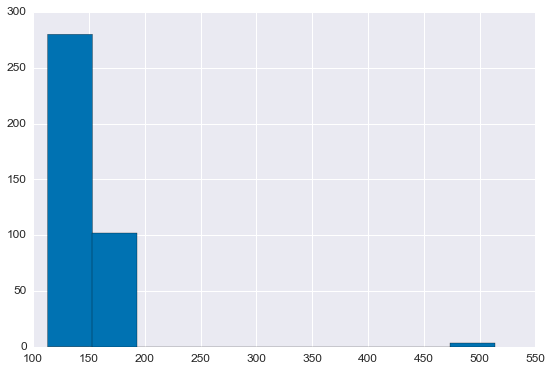

In [37]:
df['dias_siembra_cosecha'] = (df['fenologia_cosecha_fecha'] - df['fenologia_siembra_fecha']).apply(
    lambda dt: dt / np.timedelta64(24, 'h'))
df['dias_siembra_cosecha'].hist()

In [36]:
values = []
for v in df['factor_rend_densidad_pl_m2'].values:
    if isinstance(v, str):
        if not v.isalnum():
            values.append(v)

pd.Series(values).value_counts()

media 150-250        38
media : 250 a 350    25
baja : - 250         18
100-154               1
dtype: int64